# (22) Dekel

**Motivation**:  Load models, visualize stuff, and more. Device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from analysis.eval import sparse_score
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Device

In [2]:
device_idx = 0
device = f'cuda:{device_idx}'

model_type = 'poisson'

## Load trainer object (contains model)

In [3]:
tr, meta = load_model_lite(
    path=pjoin(tmp_dir, 'Dekel', 'pois-lin'),
    device=device,
    verbose=True,
)
print(meta)

# params: 262.7 K

{
    'checkpoint': 3600,
    'global_step': 385200,
    'file': 'PoissonVAE+TrainerVAE-3600_(2024_04_11,15:33).pt',
    'path': '/home/hadi/Dropbox/git/jb-vae/tmp/Dekel/pois-lin'
}

### Print basic info

In [4]:
tr.model.print()
print(f"{tr.model.cfg.name()}\n{tr.cfg.name()}")

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  PoissonVAE |  262.7 K   |
|     ---     |    ---     |
|    fc_enc   |  131.1 K   |
|    fc_dec   |  131.1 K   |
+-------------+------------+

poisson_uniform_c(-3)_rmax(0.99)_DOVES_z-512_<lin|lin>
mc_ep3600-b1000-lr(0.005)_beta(1:0x0.5)_temp(0.05:exp-1)_gr(500)

## Access to dataset

In [5]:
# these are train/validation data loaders
tr.dl_trn, tr.dl_vld

(<torch.utils.data.dataloader.DataLoader at 0x7f5ca68ddc90>,
 <torch.utils.data.dataloader.DataLoader at 0x7f5d982118d0>)

In [6]:
# how to extract image patcehs (to train LCA, FISTA, etc)
x_trn = tr.dl_trn.dataset.x
x_vld = tr.dl_vld.dataset.x

x_trn.shape, x_vld.shape

(torch.Size([107520, 1, 16, 16]), torch.Size([28224, 1, 16, 16]))

## Train

* takes around 30 min
* no need to run, just for demo

In [7]:
# comment = tr.cfg.name()
# tr.train(comment=comment)

## Eval

In [8]:
data, loss, rates = tr.validate()

_loss = {k: v.mean() for k, v in loss.items()}
_loss['tot'] = _loss['mse'] + _loss['kl']
print(_loss)

{'mse': 136.86632, 'kl': 29.927406, 'kl_diag': 0.057780832, 'tot': 166.79373}

### Find dead neurons
method: kl below certain threshold

In [9]:
dead_thres = 0.003
dead = loss['kl_diag'] < dead_thres
dead.sum()

2

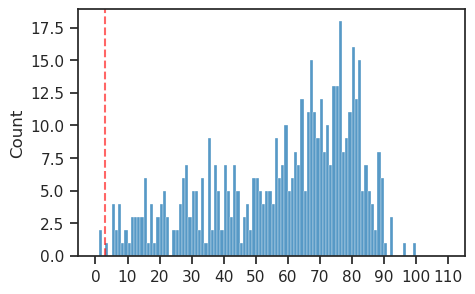

In [10]:
ax = sns.histplot(loss['kl_diag'] * 1000, bins=np.linspace(0, 110, 111))
ax.locator_params(axis='x', nbins=15)
ax.axvline(dead_thres * 1000, color='r', ls='--', alpha=0.6)
plt.show()

### Spike counts, sparsity scores, etc

In [11]:
lifetime, population, percents = sparse_score(data['z'][:, ~dead], cutoff=0.05)
percents

{'0': 73.8, '1': 20.5, '2': 4.5, '3+': 1.2}

#### Plot portion spikes

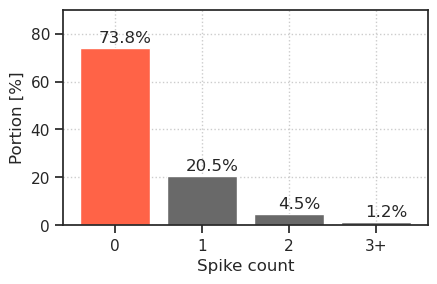

In [12]:
fig, ax = create_figure(1, 1, (4.7, 2.8))

max_val = float(list(percents.values())[0])
ax.set(
    xlabel='Spike count',
    ylabel='Portion [%]',
    ylim=(0, (np.ceil(max_val / 10) + 1) * 10),
)
colors = ['tomato' if lbl == '0' else 'dimgrey' for lbl in percents]
bars = ax.bar(percents.keys(), percents.values(), color=colors)

for bar in bars:
    y = bar.get_height()
    x = bar.get_x() + 1.3 * bar.get_width() / 2
    plt.text(x, y + 1, f'{y:0.1f}%', ha='center', va='bottom')

ax.locator_params(axis='y', nbins=5)

ax.grid()
plt.show()

#### Plot sparsity scores

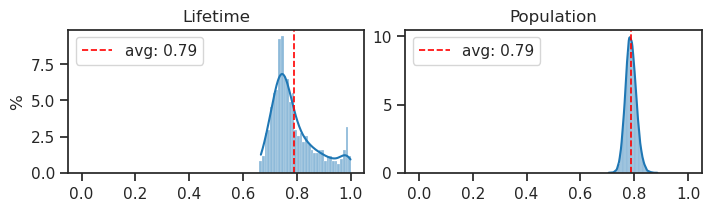

In [13]:
fig, axes = create_figure(1, 2, (7, 2), layout='constrained')

sns.histplot(lifetime, stat='percent', bins=np.linspace(0.0, 1.0, 101), kde=True, ax=axes[0])
sns.histplot(population, stat='percent', bins=np.linspace(0.0, 1.0, 201), kde=True, ax=axes[1])

for i, x2p in enumerate([lifetime, population]):
    _a, _med = np.nanmean(x2p), np.nanmedian(x2p)
    axes[i].axvline(_a, color='r', lw=1.2, ls='--', label=f'avg: {_a:0.2f}')

add_legend(axes)
axes[0].set(title='Lifetime', ylabel='%')
axes[1].set(title='Population', ylabel='')
plt.show()

### Plot dec/enc weights

In [14]:
log_r8s = to_np(tr.model.log_rates.squeeze())
order = np.argsort(log_r8s)

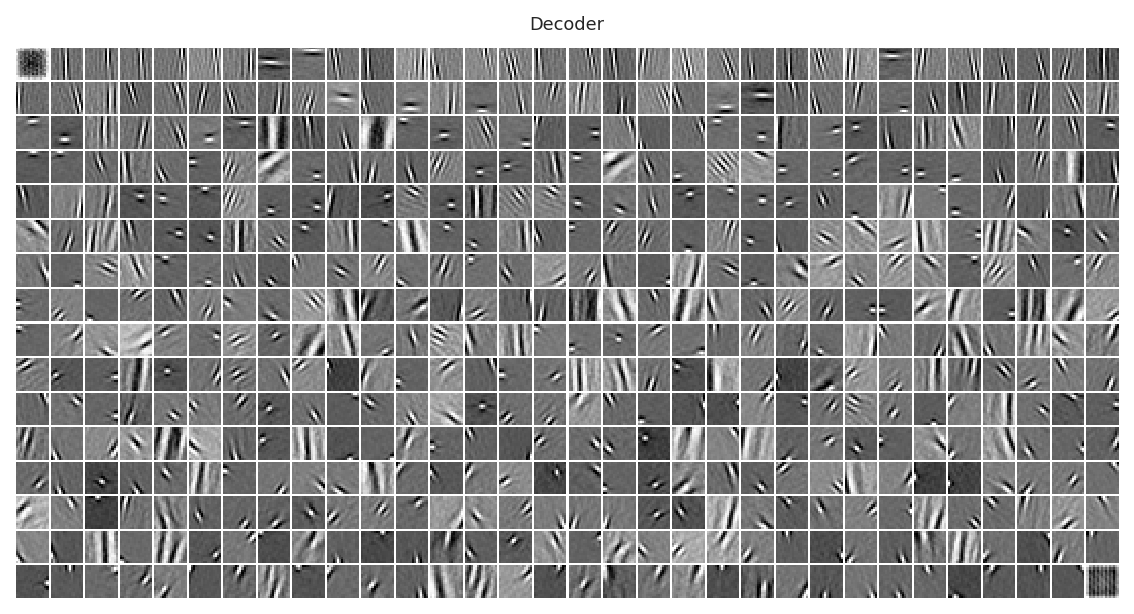

In [15]:
_ = tr.model.show('dec', order=order)

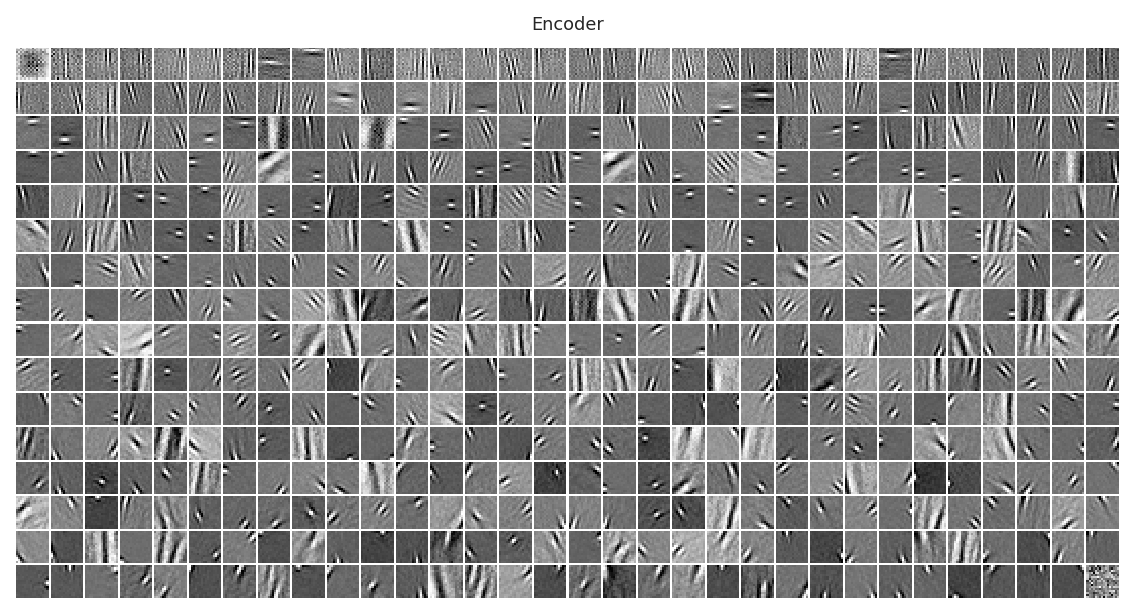

In [16]:
_ = tr.model.show('enc', order=order)

## Log-Gabor fit

In [17]:
from analysis.eval import fit_loggabor
from figures.theta import plot_theta

In [18]:
results = fit_loggabor(tr, verbose=True)

 72%|███████▉   | 367/512 [00:13<00:03, 41.53it/s]

100%|███████████| 512/512 [00:18<00:00, 27.57it/s]


In [19]:
results.loc[results['sf_0'] > 10, 'sf_0'] = np.nan
results.iloc[np.logical_or(dead, np.isnan(results['theta']))] = np.nan

results.describe()

,x_pos,y_pos,theta,sf_0,phase,B_sf,B_theta,theta_deg,r_prior
count,506.000000,506.000000,506.000000,504.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,7.460170,7.497226,-0.008462,0.302944,-0.131909,0.492073,0.404243,95.918305,0.318872
std,3.873387,4.165682,1.023898,0.421653,1.215898,0.703807,0.478198,47.301345,0.138436
min,0.373114,0.000169,-1.570796,0.092549,-3.477418,0.055032,0.066851,0.073860,0.003753
25%,4.283290,3.914037,-1.021056,0.223653,-0.863336,0.351807,0.193769,59.310757,0.231777
50%,7.485892,7.459254,-0.027418,0.253179,-0.120043,0.438129,0.306499,95.855849,0.346309
75%,10.581800,10.971964,0.952680,0.293878,0.549970,0.508073,0.531362,131.472945,0.417034
max,15.530416,15.013859,1.570796,6.479578,3.854644,13.466557,7.637997,179.963831,0.580407


## Make figs

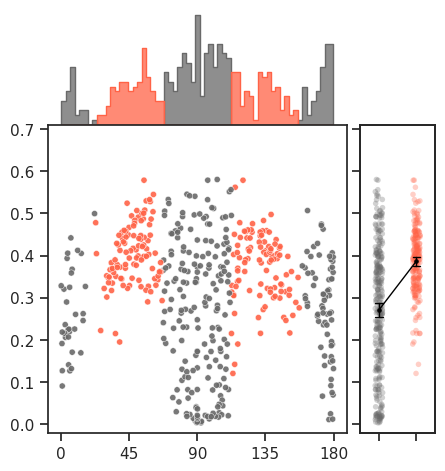

In [20]:
_ = plot_theta(results)

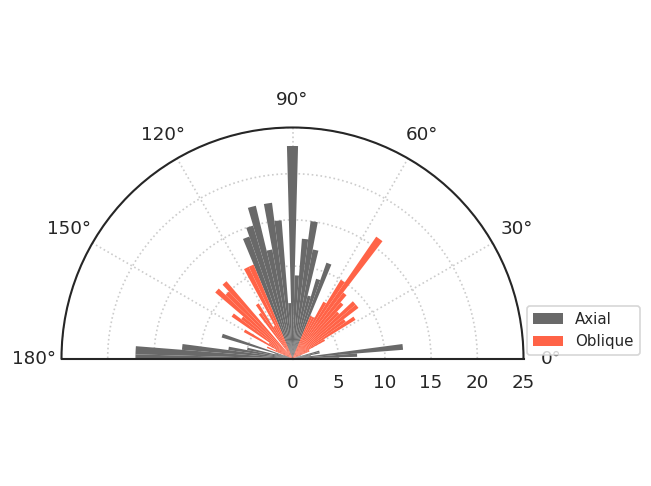

In [21]:
bin_width = 3.0
bins = np.linspace(
    start=0,
    stop=180 + bin_width,
    num=int(np.ceil(180 / bin_width)) + 2,
) - bin_width / 2
bin_mid = np.deg2rad((bins[:-1] + bins[1:]) / 2)

axial_hist, _ = np.histogram(results.loc[results['label'] == 'axial', 'theta_deg'], bins)
oblique_hist, _ = np.histogram(results.loc[results['label'] == 'oblique', 'theta_deg'], bins)

fig, ax = create_figure(1, 1, (8, 5), dpi=120, subplot_kw={'polar': True})
ax.set_thetamin(0)
ax.set_thetamax(180)
ax.set_theta_direction(1)  # Counter-clockwise
ax.set_theta_zero_location('E')  # 0 degrees to the left

ax.bar(bin_mid, axial_hist, width=np.radians(bin_width), color='dimgrey', edgecolor='none', label='Axial')
ax.bar(bin_mid, oblique_hist, width=np.radians(bin_width), color='tomato', edgecolor='none', label='Oblique', bottom=axial_hist)
ax.legend(fontsize=9)
move_legend(ax, (0.992, 0.38))
ax.set_ylim((0, 25))
plt.show()

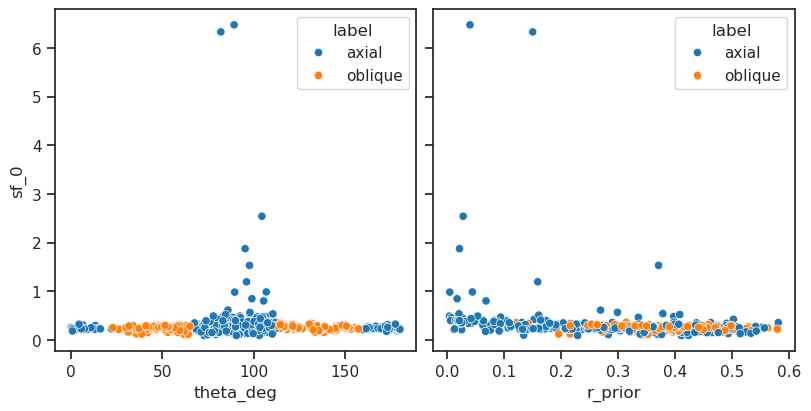

In [22]:
fig, axes = create_figure(1, 2, (8, 4), sharey='row', layout='constrained')
sns.scatterplot(data=results, y='sf_0', x='theta_deg', hue='label', ax=axes[0])
sns.scatterplot(data=results, y='sf_0', x='r_prior', hue='label', ax=axes[1])
plt.show()

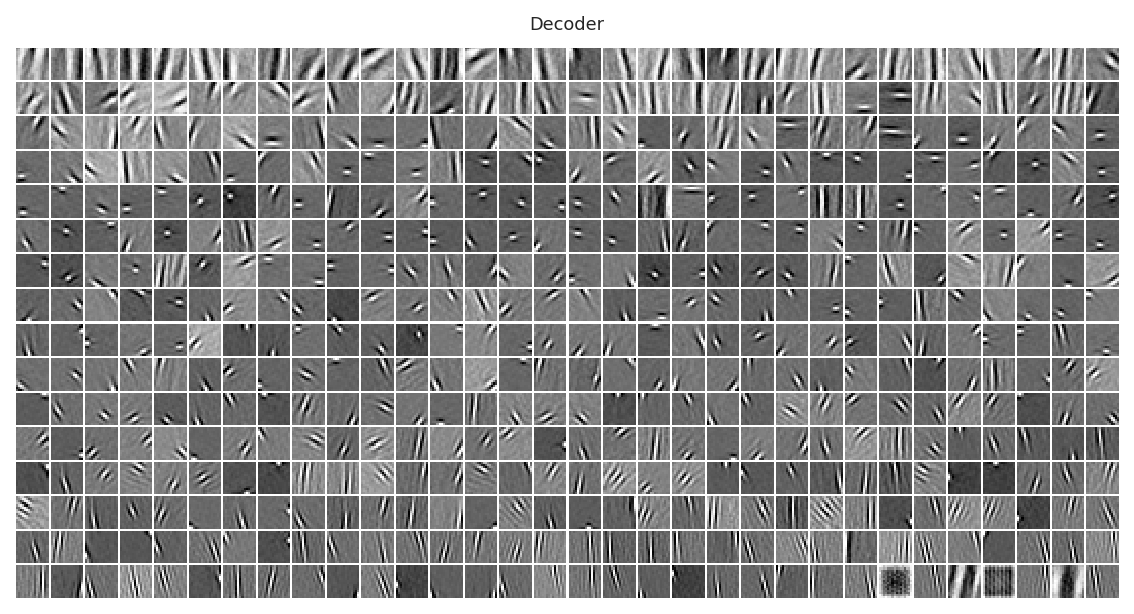

In [23]:
order = np.argsort(results['sf_0'].values)
_ = tr.model.show('dec', order=order)

### High and low spatial frequencies

In [24]:
w = to_np(tr.model.fc_dec.weight.data)
w = w.T.reshape(-1, 16, 16)
w.shape

(512, 16, 16)

In [25]:
inds = np.argsort(results['sf_0'].values)

In [26]:
from figures.weight import plot_weights

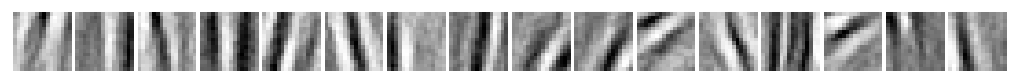

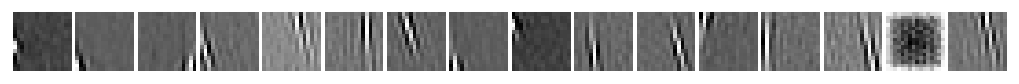

In [27]:
plot_weights(w[inds[:16]], nrows=1, dpi=130)
plt.show()

plot_weights(w[inds[-21:-5]], nrows=1, dpi=130)
plt.show()

## statistical tests

In [28]:
rates_axial = results.loc[(results['label'] == 'axial') & ~dead, 'r_prior'].values
rates_oblique = results.loc[(results['label'] == 'oblique') & ~dead, 'r_prior'].values

In [29]:
sp_stats.mannwhitneyu(rates_axial, rates_oblique, method='auto')

MannwhitneyuResult(statistic=16700.0, pvalue=8.562204958821399e-19)